# ADZD Lab2 - DataFrame
**Author: Bartłomiej Jamiołkowski**

Using Spark DataFrame API.

## Libraries

In [81]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.sql.types import FloatType, IntegerType, StringType
from pyspark.sql.functions import udf, col, asc, sum, count, desc, when, lit , coalesce
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import re

## Spark initialization

In [82]:
spark = SparkSession.builder.getOrCreate()
spark

In [83]:
sc = spark.sparkContext

## Data retrieval

In [84]:
countries = spark.read.csv('countries of the world.csv', inferSchema=True, header=True)
airports = spark.read.csv('airports.csv', inferSchema=True, header=False)

In [85]:
countries.createOrReplaceTempView("countries")
airports.createOrReplaceTempView("airports")

In [86]:
countries.toPandas().head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None


In [87]:
airports.toPandas().head()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


## Exercise 1
Plot the dependence of the Birthrate and Deathrate columns on GDP per capita for the 30 richest countries (dependence of Birthrate on GDP and Deathrate on GDP on one plot with different colors) and the 30 poorest countries (similarly)

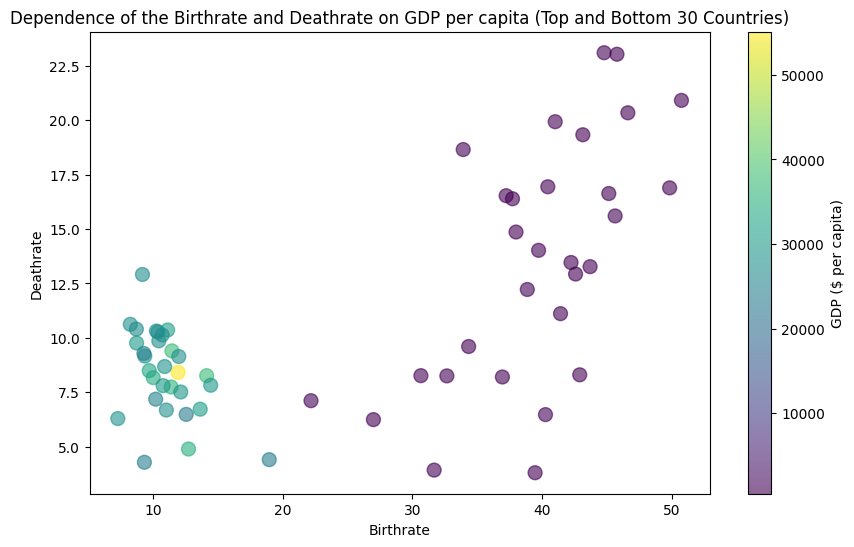

In [88]:
float_udf = udf(lambda s: float(s.replace(',', '.')), FloatType())

birth_death_gdp_countries_df = (countries
    .select('Birthrate', 'Deathrate', 'GDP ($ per capita)')
    .na.drop()
    .withColumn('Birthrate', float_udf('Birthrate'))
    .withColumn('Deathrate', float_udf('Deathrate'))
    .withColumn('GDP ($ per capita)', col('GDP ($ per capita)').cast('float'))
    .orderBy(desc('GDP ($ per capita)')))

top_30_rich_countries_df = spark.createDataFrame(birth_death_gdp_countries_df.head(30)).toPandas()  
top_30_poor_countries_df = spark.createDataFrame(birth_death_gdp_countries_df.tail(30)).toPandas()
combined_df = pd.concat([top_30_rich_countries_df, top_30_poor_countries_df])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    combined_df['Birthrate'], 
    combined_df['Deathrate'], 
    c=combined_df['GDP ($ per capita)'],
    cmap='viridis',
    s=100,
    alpha=0.6)

plt.colorbar(scatter, label='GDP ($ per capita)')
plt.title('Dependence of the Birthrate and Deathrate on GDP per capita (Top and Bottom 30 Countries)')
plt.xlabel("Birthrate")
plt.ylabel("Deathrate")
plt.show()

Obtained results can be interpreted as follows:
- In the scatterplot above, there are two noticeable groups of countries. The countries on the left represent the top 30 richest countries on the planet, while those on the right represent the top 30 poorest countries.
- The scatterplot indicates that as GDP per capita decreases, the Birthrate tends to increase.
- The scatterplot also suggests that as GDP per capita decreases, the Deathrate tends to increase, indicating a decline in the quality of healthcare.

## Exercise 2
Load the "airports.csv" dataset from https://www.kaggle.com/jonatancr/airports (it contains data on airports from all over the world). Since there is no header in this dataset, give your own column names using the file description on this page. Plot the positions of all/selected airports on a graph (map).

In [89]:
airport_columns = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 
                   'Tz database time zone', 'Type', 'Source']

airports = airports.toDF(*airport_columns)
airports = airports.withColumnRenamed('Latitude\t', 'Latitude')

In [90]:
airports.toPandas().head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


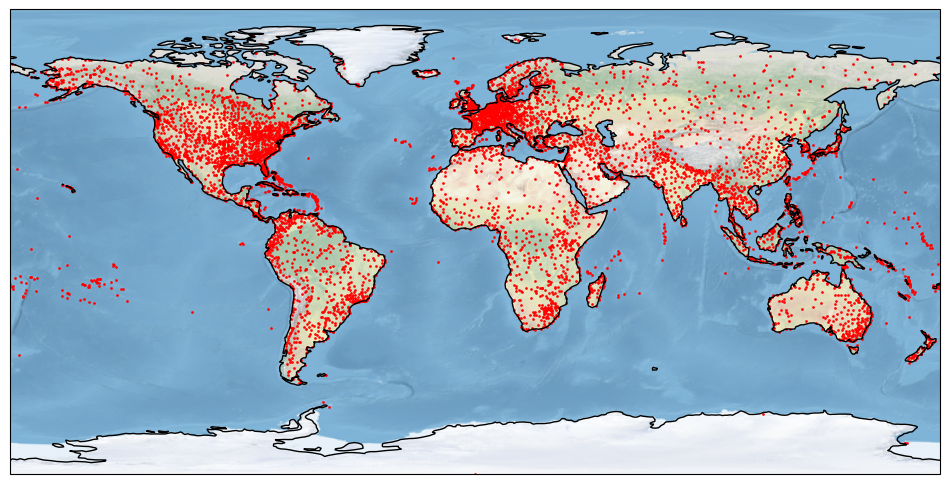

In [91]:
locations_df = airports.select('Latitude','Longitude').toPandas()
latitudes = list(locations_df['Latitude'])
longitudes = list(locations_df['Longitude'])

plt.figure(figsize = [12, 8])
ax = plt.axes(projection = ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

plt.scatter(x=longitudes, y=latitudes, color='r', s=1, alpha=0.9, transform=ccrs.PlateCarree())
plt.show()

## Exercise 3
Find 10 countries where the lowest airport has the highest altitude, giving the results in metres above sea level.

In [92]:
airports.createOrReplaceTempView("airports")

In [93]:
query_ex3 = 'SELECT Country, MIN(Altitude * 0.3048) AS Min_Altitude_MASL FROM airports GROUP BY Country ORDER BY Min_Altitude_MASL DESC LIMIT 10;'
top_10_airports_df = spark.sql(query_ex3).toPandas()
top_10_airports_df

,Country,Min_Altitude_MASL
0,Lesotho,1556.0040
1,Rwanda,1481.0232
2,Burundi,786.9936
3,West Bank,757.4280
4,Uganda,753.4656
5,Swaziland,632.4600
6,Kyrgyzstan,627.2784
7,Botswana,540.1056
8,Malawi,481.5840
9,South Sudan,461.1624


## Exercise 4
On a scatterplot, draw the relationship between the number of airports and the area of ​​the country.
- The data needed for the chart is in two frames (Countries and Airports), so it will be necessary to join them.
- The names of the same countries will not always be identical in both frames, which can be a problem (the join will not be created). Think about how to detect which names differ using the join mechanism. Create the appropriate frame that contains such names.

In [94]:
raw_joined_outer_df = (countries_trimmed
    .join(airports_trimmed, on = 'Country', how = 'outer')
    .withColumn('InCountries', when(countries_trimmed['Country'].isNotNull(), 1).otherwise(0))
    .withColumn('InAirports', when(airports_trimmed['Country'].isNotNull(), 1).otherwise(0))
)

country_names_df = raw_joined_outer_df.select(
    coalesce(countries_trimmed['Country'], lit('')).alias('Country_Variant_1'),
    coalesce(airports_trimmed['Country'], lit('')).alias('Country_Variant_2')
)

country_names_unique_df = country_names_df.filter(col('Country_Variant_1') != col('Country_Variant_2')).toPandas()
country_names_unique_df = country_names_unique_df.drop([0, 1, 8, 13, 14, 19, 22, 23, 26, 29, 30, 31, 32, 34, 35, 38, 42, 46, 48, 53]).reset_index(drop = True)
col_1_df = country_names_unique_df['Country_Variant_1'].replace('', np.nan).dropna(how = 'all').reset_index(drop = True)
col_2_df = country_names_unique_df['Country_Variant_2'].replace('', np.nan).dropna(how = 'all').reset_index(drop = True)
col_2_list = list(col_2_df)
col_2_list.remove('North Korea')
col_2_list.remove('South Korea')
col_2_list.remove('Saint Pierre and Miquelon')
col_2_list.insert(8, 'North Korea')
col_2_list.insert(9, 'South Korea')
col_2_list.insert(14, 'Saint Pierre and Miquelon')
col_2_df = pd.DataFrame(col_2_list)
country_names_unique_df = pd.concat([col_1_df, col_2_df], axis = 1)
country_names_unique_df

,Country_Variant_1,0
0,Antigua & Barbuda,Antigua and Barbuda
1,"Bahamas, The",Bahamas
2,Bosnia & Herzegovina,Bosnia and Herzegovina
3,British Virgin Is.,British Virgin Islands
4,Central African Rep.,Central African Republic
5,"Congo, Dem. Rep.",Congo (Brazzaville)
6,"Congo, Repub. of the",Congo (Kinshasa)
7,"Gambia, The",Gambia
8,"Korea, North",North Korea
9,"Korea, South",South Korea


In [46]:
def normalize_country_name(name: str) -> str:
    names_dict = {
        'Korea, North': 'North Korea',
        'Korea, South': 'South Korea',
        'Rep.': 'Republic',
        'Islands': 'Island',
        'Is.': 'Island',
        '&': 'and',
        ', The': ''}

    for old_name, new_name in names_dict.items():
        name = name.replace(old_name, new_name)

    name = re.sub(r'Congo, D*', 'Congo (Kinshasa)', name)
    name = re.sub(r'Congo, R*', 'Congo (Brazzaville)', name)
    name = re.sub(r'N. Mariana Is.', 'Northern Mariana Islands', name)
    name = re.sub(r'Micronesia.*', 'Micronesia', name)
    name = re.sub(r'\bIs(\s+|$)', 'Island', name)
    
    
    return name.strip()


normalize_country_name_udf = udf(normalize_country_name, StringType())

In [49]:
countries_df = (countries
    .withColumnRenamed('Area (sq. mi.)', 'Area')
    .select('Country', 'Area')
    .withColumn("Country", normalize_country_name_udf('Country')))

airports_df = (airports
    .select('Country')
    .withColumn('Country', normalize_country_name_udf('Country')))

joined_df = (countries_df
    .join(airports_df, on = 'Country', how = 'left')
    .groupBy('Country', 'Area')
    .agg(count('Country').alias('Count'))
    .orderBy('Area'))

joined_df_pd = joined_df.toPandas()
joined_df_pd.head()

,Country,Area,Count
0,Monaco,2,1
1,Gibraltar,7,1
2,Nauru,21,1
3,Tuvalu,26,1
4,Macau,28,1


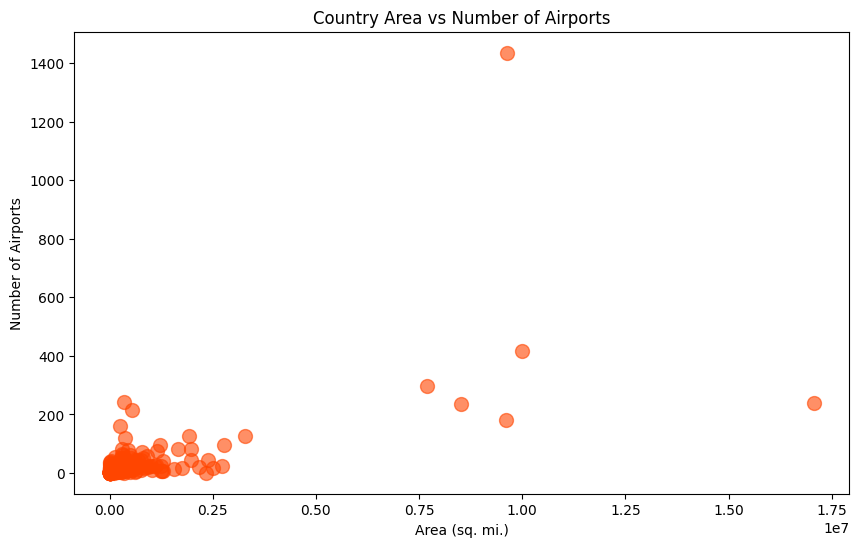

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(
    joined_df_pd['Area'], 
    joined_df_pd['Count'],
    color='orangered',
    s=100,
    alpha=0.6)

plt.title('Country Area vs Number of Airports')
plt.xlabel("Area (sq. mi.)")
plt.ylabel("Number of Airports")
plt.show()

## Exercise 5
Calculate how many airports there are on each continent. This task also requires merging the "Countries" and "Airports" frames. Plot the result in a pie chart.

In [17]:
def region_to_continent(name: str) -> str:
    other_name = 'Other'
    continents_dict = {
        'AFRICA': 'Africa',
        'ASIA': 'Asia',
        'BALTICS': 'Europe',
        'EUROPE': 'Europe',
        'IND. STATES': 'Asia',
        'LATIN AMER': 'South America',
        'NEAR EAST': 'Africa',
        'NORTHERN AMERICA': 'North America',
        'OCEANIA': 'Australia/Oceania'}
    
    for old_name, new_name in continents_dict.items():
        if old_name in name:
            return new_name
    
    return other_name


region_to_continent_udf = udf(lambda name: region_to_continent(name), StringType())

In [18]:
countries_df = (countries
    .select('Country', 'Region')
    .withColumn('Country', normalize_country_name_udf('Country'))
    .withColumn('Continent', region_to_continent_udf('Region'))
    .drop("Region"))

airports_df = (airports
    .select('Country')
    .withColumn('Country', normalize_country_name_udf('Country')))

joined_df = (countries_df
    .join(airports_df, on='Country', how='left')
    .drop('Country')
    .groupBy('Continent')
    .agg(count('Continent'))
    .orderBy(desc('Continent'))
)

joined_df_pd = joined_df.toPandas()
joined_df_pd

,Continent,count(Continent)
0,South America,969
1,North America,1876
2,Europe,1399
3,Australia/Oceania,547
4,Asia,1454
5,Africa,963


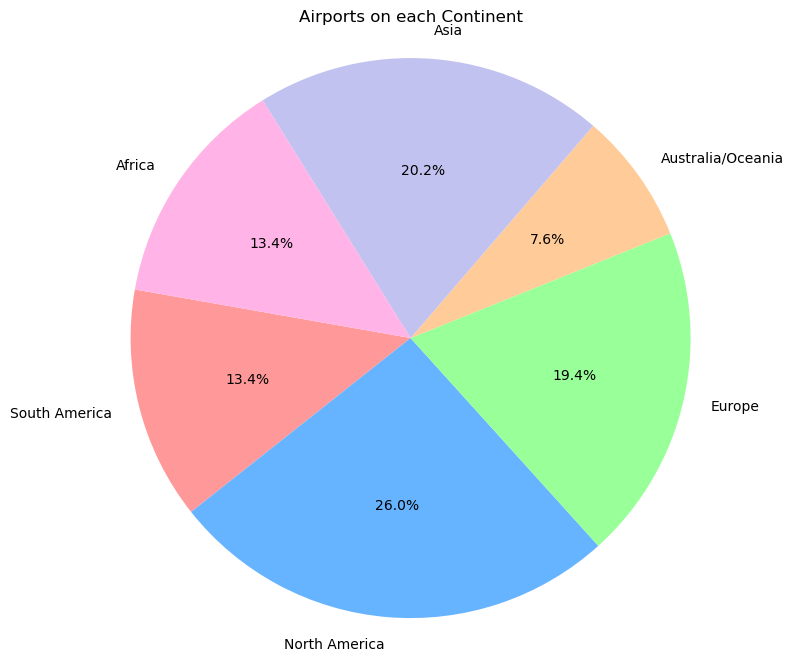

In [19]:
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

plt.figure(figsize=(10, 8))
plt.pie(x = joined_df_pd['count(Continent)'], labels=joined_df_pd['Continent'], autopct='%1.1f%%', startangle=170, colors = colors)
plt.axis('equal')
plt.title('Airports on each Continent')
plt.show()